In [67]:
%matplotlib inline

import cv2 # The OpenCV library; install using `pip install opencv-contrib-python`
import numpy as np # Helpful when working with arrays; install using `pip install numpy`
from matplotlib import pyplot as plt # Good for graphing; install using `pip install matplotlib`
from matplotlib import image as image
import easygui # An easy-to-use file-picker; pip install easygui

debug = 1 #set to 1 to see each step set to 0 to run fast
cursed = 0

take in the image of the dice and set it up corectly

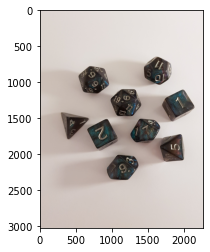

In [3]:
fileName = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])
diceRaw = cv2.imread(fileName,cv2.IMREAD_COLOR)
#if its a jpg it will need to have its color converted
if(fileName[-4:] == ".jpg" or fileName[5:] == ".jpeg"):
    diceRaw = cv2.cvtColor(diceRaw,cv2.COLOR_RGB2BGR)
if debug == 1:
    plt.imshow(diceRaw)

make the image grey

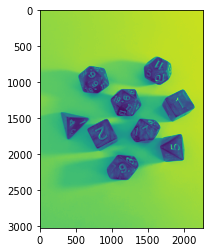

In [4]:
diceGrey = cv2.cvtColor(diceRaw, cv2.COLOR_BGR2GRAY)
if debug == 1:
    plt.imshow(diceGrey)

threhold the image (using stats!)

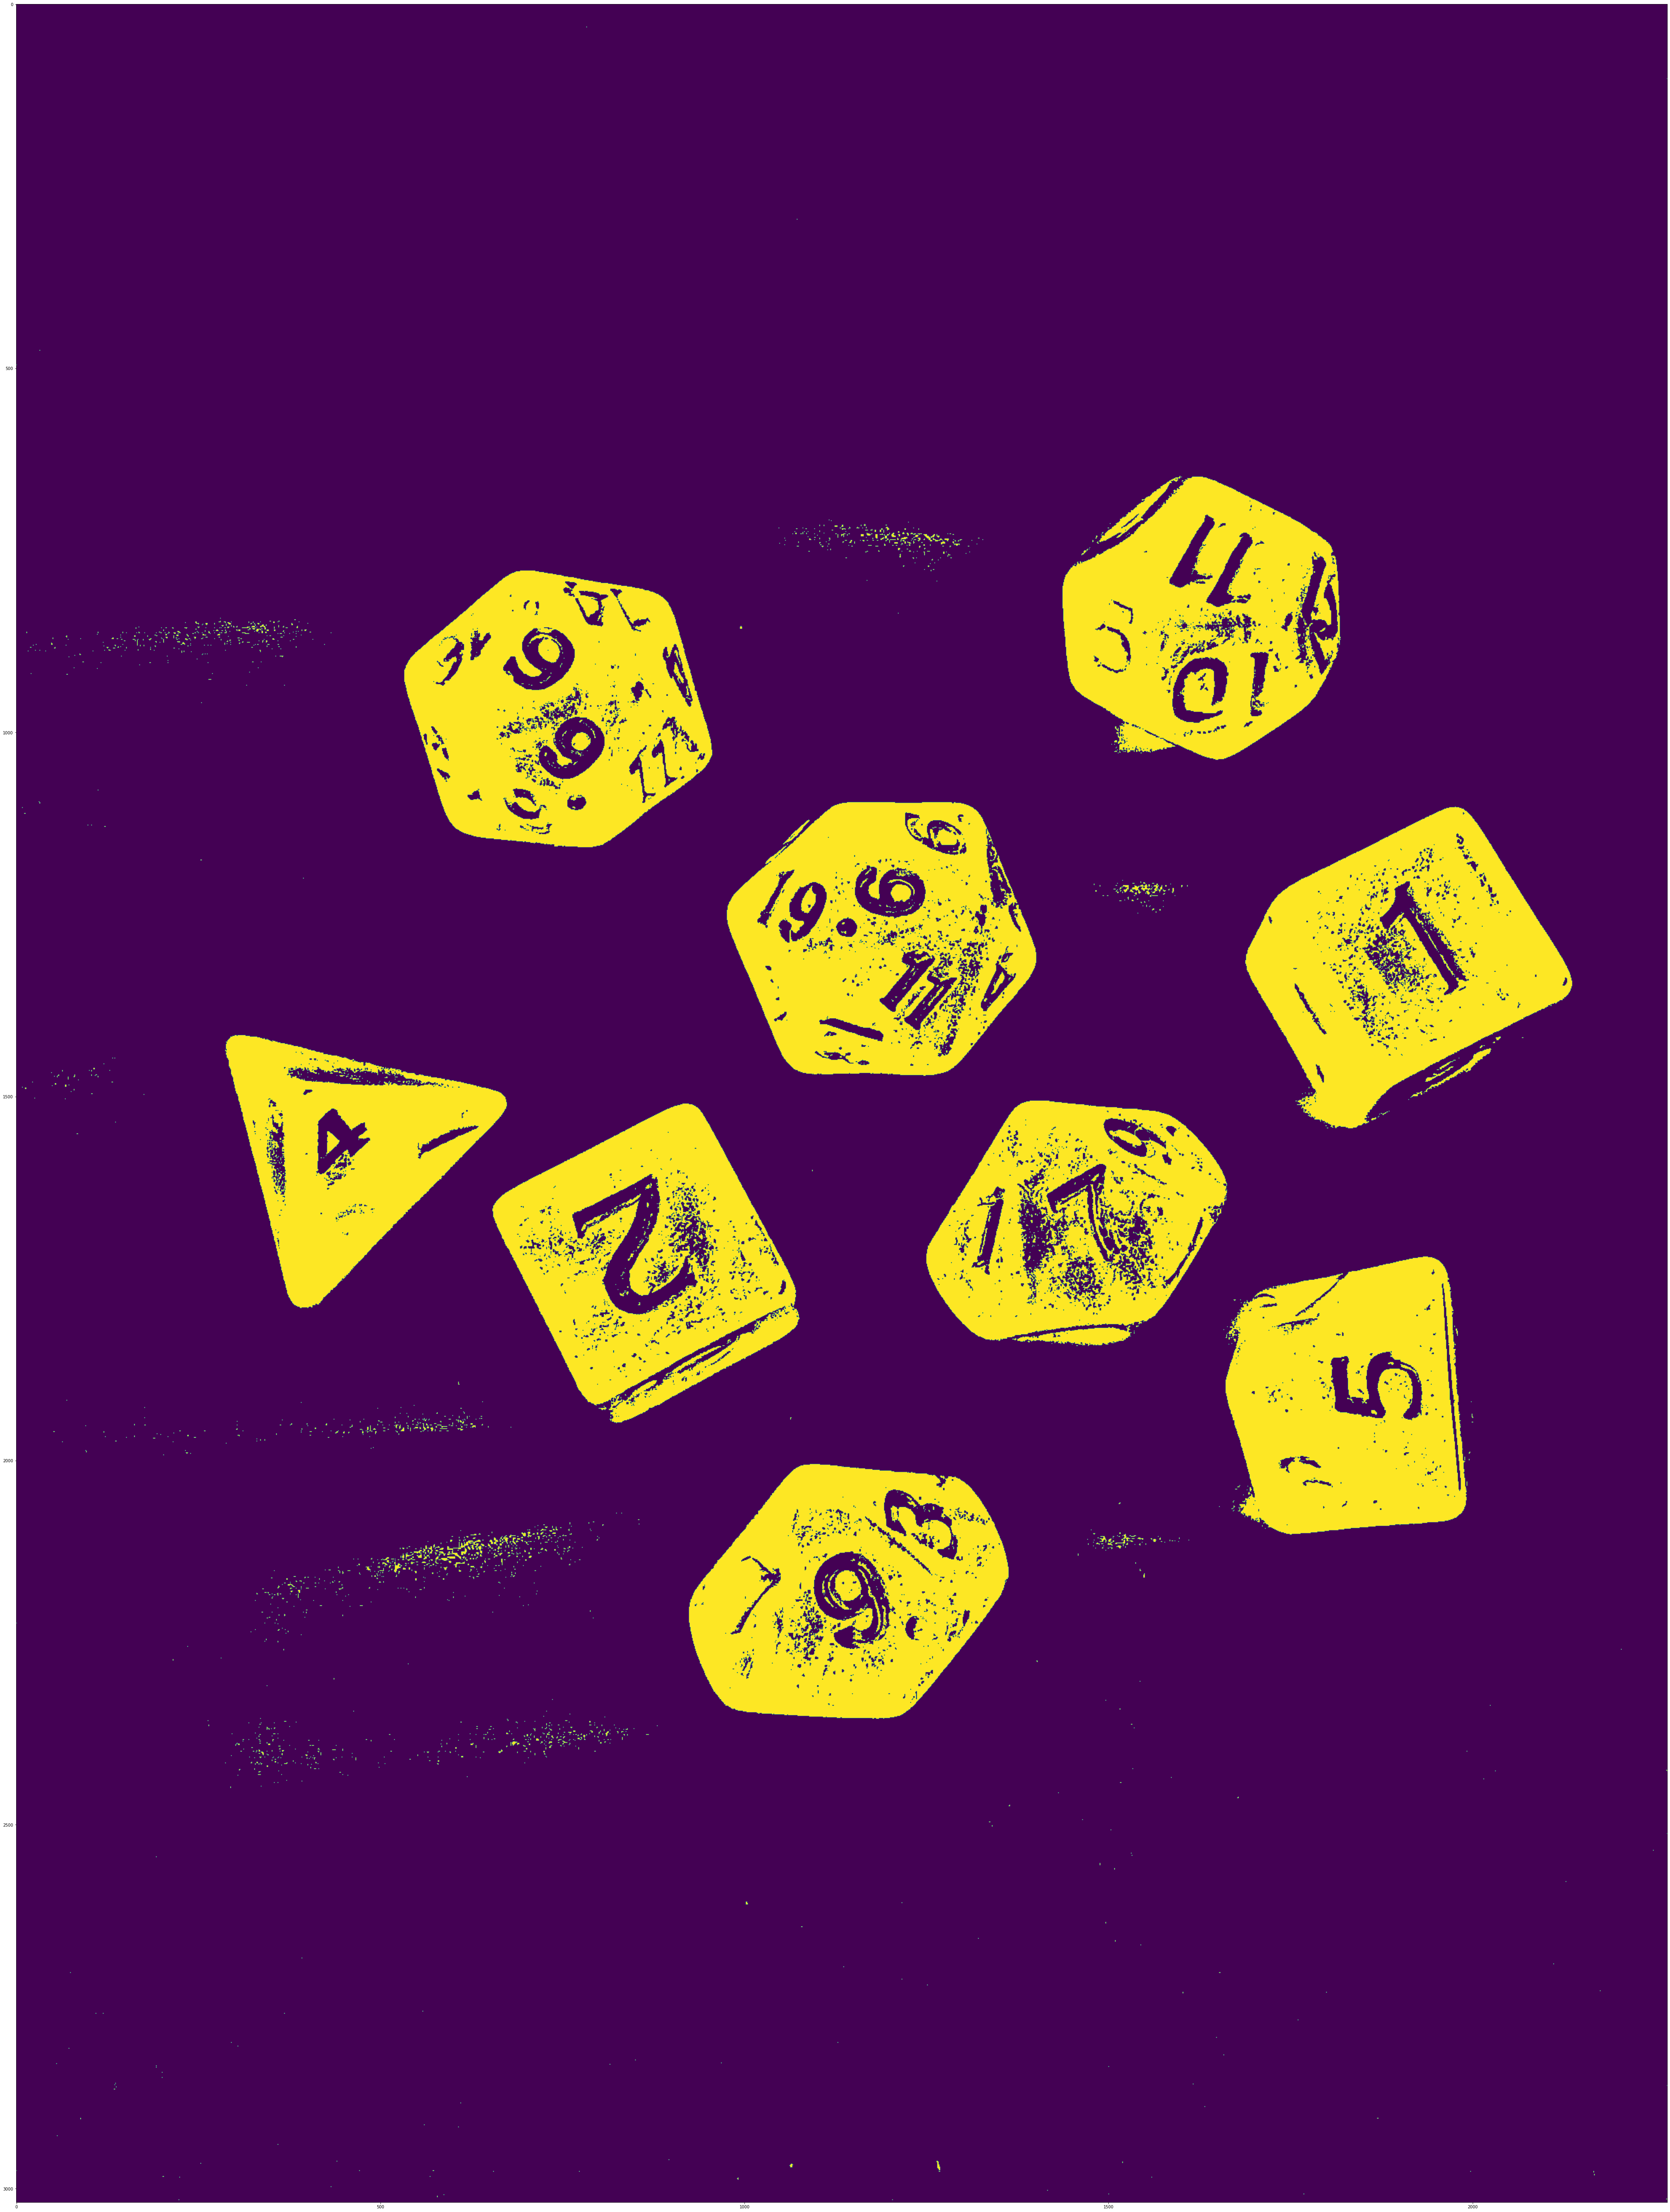

In [5]:
#MAGIC
thresholdConsant = (np.mean(diceGrey) + np.std(diceGrey))/25
threshholdedAllDice = cv2.adaptiveThreshold(diceGrey, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 501,thresholdConsant)
if debug == 1:
    plt.figure(figsize=(100,100))
    plt.imshow(threshholdedAllDice)

preform some clean up on the image so that making the conturs dosent take a millon years

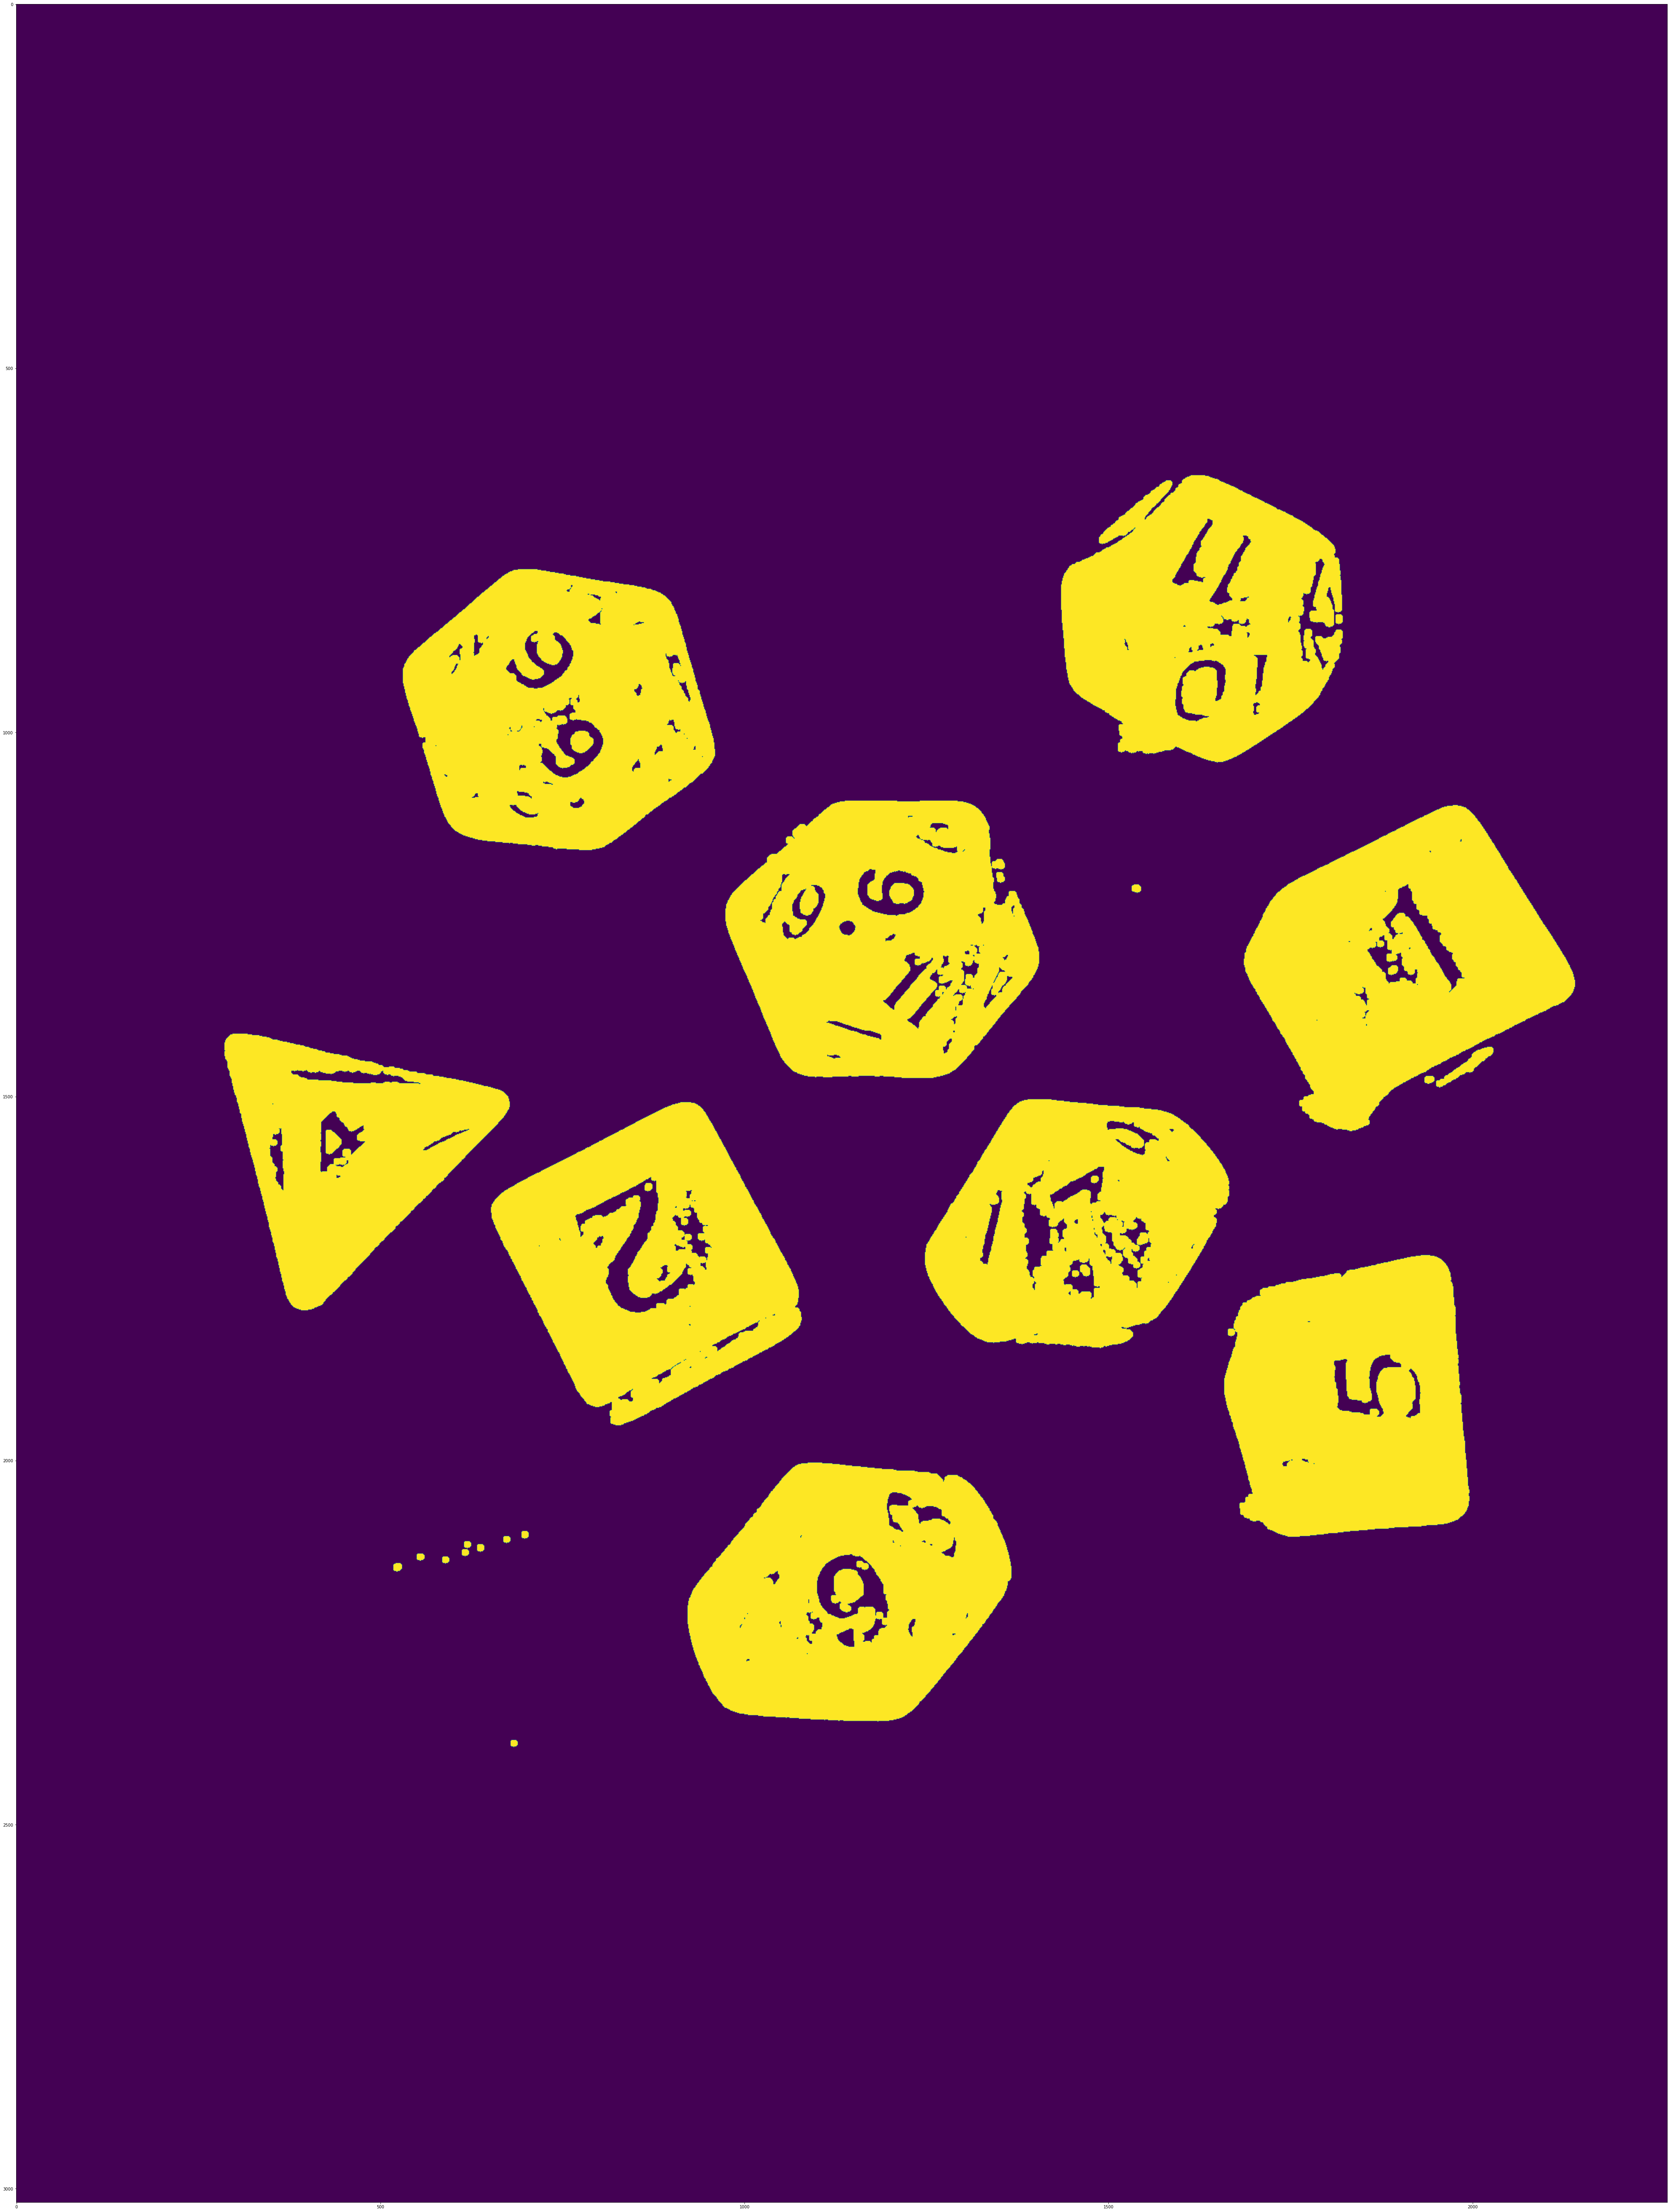

In [6]:
#MAGIC
circle4x4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
circle10x10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
circle3x3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
circle15x15 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))

diceMask = cv2.erode(threshholdedAllDice,circle4x4)
diceMask = cv2.dilate(diceMask,circle10x10)
#diceMask = cv2.erode(threshholdedAllDice,circle15x15)
#diceMask = cv2.dilate(diceMask,circle15x15)
#diceMask = cv2.dilate(diceMask,circle15x15)


if debug == 1:
    plt.figure(figsize=(100,100))
    plt.imshow(diceMask)

where going to make a few assumtions here:

    1 the largeret contour is a dice

    2 any contur 50 smaller than the largest contur isnt a dice
    
    with this we can filter out all the little dots that got left over

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


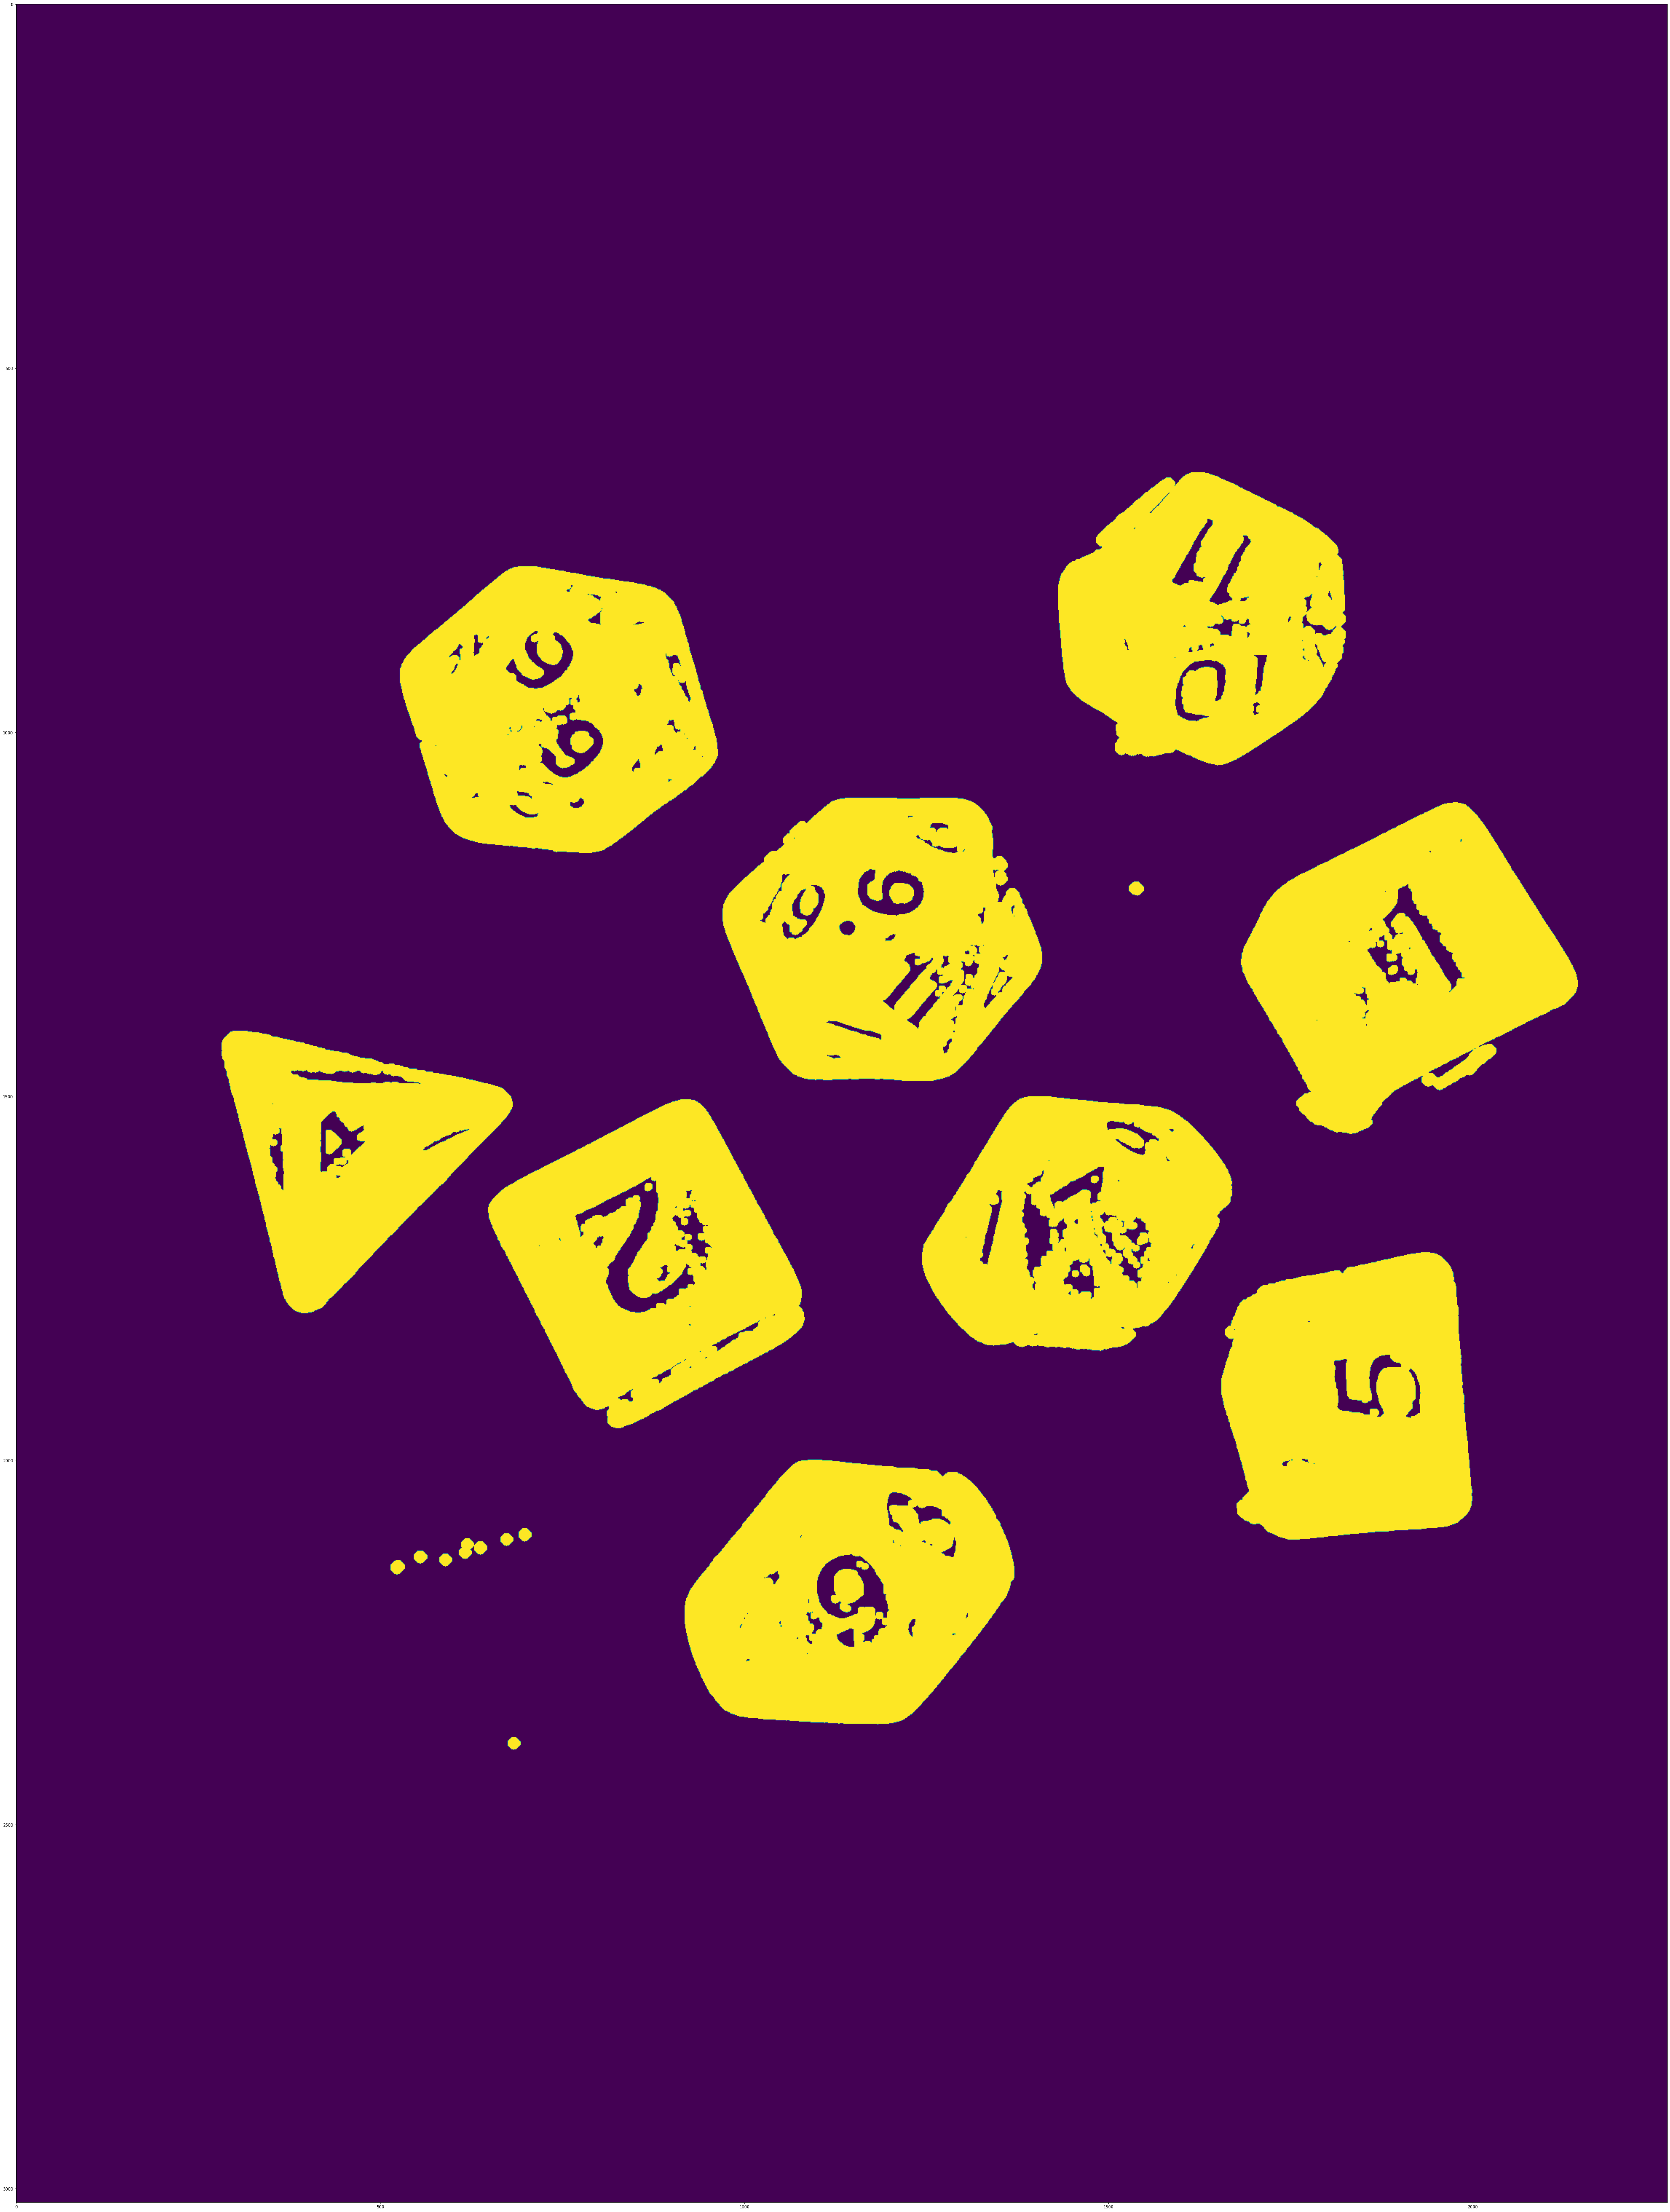

In [48]:
#step 1 getting the largest contur
contours, hierarchy  = cv2.findContours(diceMask, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
if debug == 1:
    tempImg = cv2.drawContours(diceMask, contours, -1, (255), 3)
    plt.figure(figsize=(100,100))
    plt.imshow(tempImg)

largestContour = 0
for i in range(len(hierarchy[0])):
    if debug == 1:
        print(i)
    if (cv2.contourArea(contours[i]) > cv2.contourArea(contours[largestContour])):
        largestContour = i

so now that we have the largest contur where going to check each contur and see if its small than 50% of the largest one
if it is discard it if it isnt we will add its bounding box to the array

bounding boxes have a X cord a Y cord and a height and a width so the array is a 2d array with that strucher

In [76]:
#some cursed stuff that doent work
if cursed == 1:
    firstArrayToAdd = [0,0,0,0]
    firstArrayToAdd[0],arrayToAdd[1],arrayToAdd[2],arrayToAdd[3] = cv2.boundingRect(contours[largestContour])
    boundingBoxes = [firstArrayToAdd]
    for i in range(len(hierarchy[0])):
        if debug == 1:
            print(cv2.boundingRect(contours[i]))
        if (cv2.contourArea(contours[i]) > (cv2.contourArea(contours[largestContour]))/2):
            arrayToAdd[0],arrayToAdd[1],arrayToAdd[2],arrayToAdd[3] = cv2.boundingRect(contours[i])
            if debug == 1:
                print(arrayToAdd)
            boundingBoxes.extend([arrayToAdd])
            if debug == 1:
                print("added:")
                print(arrayToAdd)
                print("bounding boxes is now:")
                print(boundingBoxes)
    if debug ==1:
        print(boundingBoxes)
else:
    boundingBoxes = []
    for i in range(len(hierarchy[0])):
        if debug == 1:
            print(cv2.boundingRect(contours[i]))
        if (cv2.contourArea(contours[i]) > (cv2.contourArea(contours[largestContour]))/2):
            j = len(boundingBoxes)
            boundingBoxes.extend([cv2.boundingRect(contours[i])])
    if debug == 1:
        print("bounding boxes is:")
        print(boundingBoxes)
    

(677, 2382, 14, 14)
(516, 2139, 16, 16)
(583, 2130, 14, 14)
(548, 2126, 15, 14)
(631, 2113, 14, 15)
(610, 2109, 17, 25)
(667, 2102, 14, 14)
(692, 2095, 14, 15)
(920, 2001, 449, 360)
(1657, 1716, 341, 391)
(650, 1506, 431, 448)
(1246, 1502, 422, 346)
(1932, 1430, 99, 60)
(284, 1412, 396, 384)
(1530, 1207, 17, 16)
(1684, 1098, 459, 452)
(972, 1092, 435, 385)
(529, 774, 433, 390)
(1433, 645, 391, 399)
bounding boxes is:
[(920, 2001, 449, 360), (1657, 1716, 341, 391), (650, 1506, 431, 448), (1246, 1502, 422, 346), (284, 1412, 396, 384), (1684, 1098, 459, 452), (972, 1092, 435, 385), (529, 774, 433, 390), (1433, 645, 391, 399)]


time to crop the orginal image into indvidual dice

In [74]:
diceImages = []
for i in range(1,int((np.size(boundingBoxes)/4))):#posibly the worst line of code ive ever writen
    x,y,h,w = boundingBoxes[i]
    diceImages.append(diceRaw[y:y+h,x:x+w])
    if debug == 1:
        print(i)
        print(boundingBoxes[i])
if debug == 1:
    for image in diceImages:
        cv2.imshow('imagen', image)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()

1
(1657, 1716, 341, 391)
2
(650, 1506, 431, 448)
3
(1246, 1502, 422, 346)
4
(284, 1412, 396, 384)
5
(1684, 1098, 459, 452)
6
(972, 1092, 435, 385)
7
(529, 774, 433, 390)
8
(1433, 645, 391, 399)


In [55]:
boundingBoxes[0][0]

1433

In [68]:
print(cv2.boundingRect(contours[1]))

(516, 2139, 16, 16)
